In [5]:
import psycopg2 as ps 
from typing import List
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
DB_HOST = 'localhost'
DB_PORT = 5433
DB_USER = 'postgres'
DB_PASSWORD = 'postgres' #bad practice
DB_DATABASE = 'Sakila_Sample_Database'

DATA_PATH = './dataframes/'

CONNECTION_STR = f"host={DB_HOST} port={DB_PORT} dbname={DB_DATABASE} user={DB_USER} password={DB_PASSWORD}"


def make_query(query: str, conn_str: str = ''):
    '''Create a query and fetching data from database
    '''
    if not conn_str:
        raise ValueError('no db connection str')

    with ps.connect(CONNECTION_STR) as conn:
        cur = conn.cursor()
        cur.execute(query)
        result = list(cur.fetchall())

    return result

db_fetch = partial(make_query, conn_str = CONNECTION_STR)

def save_to_csv(data: List[tuple], columns, filename: str):
    
    pd.DataFrame(data, columns=columns).to_csv(DATA_PATH + filename)

In [7]:
from sqlalchemy import create_engine, Column, Integer, DateTime, Float, String
from sqlalchemy.orm import declarative_base, sessionmaker
import datetime

# Создание базового класса для моделей
Base = declarative_base()

# Определение модели "Product"
class Actor(Base):
    __tablename__ = 'actor'  # Имя таблицы в БД

    actor_id = Column(Integer, primary_key=True, autoincrement=True)
    first_name = Column(String(100), nullable=False)
    last_name = Column(String(100), nullable=False)
    last_update = Column(DateTime())

    def __repr__(self):
        return f"<Actor(name={self.first_name}, last_name={self.last_name}, actor_id={self.actor_id})>"

class Movie(Base):
    __tablename__ = 'film'

    film_id = Column(Integer, primary_key=True, autoincrement=True)
    title = Column(String(100), nullable=False)
    description = Column(String(100), nullable=False)
    release_year = Column(Integer)
    language_id = Column(Integer)
    rental_duration = Column(Integer)
    rental_rate = Column(Float)
    length = Column(Integer)
    rating = Column(String(100))
    special_features = Column(String(100))

    def __repr__(self):
        return f"<Movie(name={self.title}, description={self.description}, release_year={self.release_year}), special_features={self.special_features}>"


# Создание подключения к базе данных 
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_DATABASE}')

# Создание сессии для работы с базой данных
Session = sessionmaker(bind=engine)
session = Session()

In [8]:
actors = session.query(Actor).limit(10).all()

print('10 Актеров: ')
print(*actors[:10], sep ='\n')


films = session.query(Movie).filter(Movie.rating == 'PG').all()

print('10 фильмов с рейтингом PG: ')
print(*films[:10], sep ='\n')

session.close()

10 Актеров: 
<Actor(name=PENELOPE, last_name=GUINESS, actor_id=1)>
<Actor(name=NICK, last_name=WAHLBERG, actor_id=2)>
<Actor(name=ED, last_name=CHASE, actor_id=3)>
<Actor(name=JENNIFER, last_name=DAVIS, actor_id=4)>
<Actor(name=JOHNNY, last_name=LOLLOBRIGIDA, actor_id=5)>
<Actor(name=BETTE, last_name=NICHOLSON, actor_id=6)>
<Actor(name=GRACE, last_name=MOSTEL, actor_id=7)>
<Actor(name=MATTHEW, last_name=JOHANSSON, actor_id=8)>
<Actor(name=JOE, last_name=SWANK, actor_id=9)>
<Actor(name=CHRISTIAN, last_name=GABLE, actor_id=10)>
10 фильмов с рейтингом PG: 
<Movie(name=ACADEMY DINOSAUR, description=A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies, release_year=2006), special_features=Deleted Scenes,Behind the Scenes>
<Movie(name=AGENT TRUMAN, description=A Intrepid Panorama of a Robot And a Boy who must Escape a Sumo Wrestler in Ancient China, release_year=2006), special_features=Deleted Scenes>
<Movie(name=ALASKA PHANTOM, description=A Fanci

In [9]:
# Какова доля фильмов в каждой рейтинговой категории(G,PG,PG-13,R ит.д.) в нашем ассортименте?
QUERY_1 = '''SELECT film.rating, COUNT(*) 
             FROM film 
             GROUP BY film.rating'''

result = db_fetch(QUERY_1)
columns = ['rating', 'film_count']
save_to_csv(result, columns, 'query_1.csv')

<Axes: xlabel='rating', ylabel='film_count'>

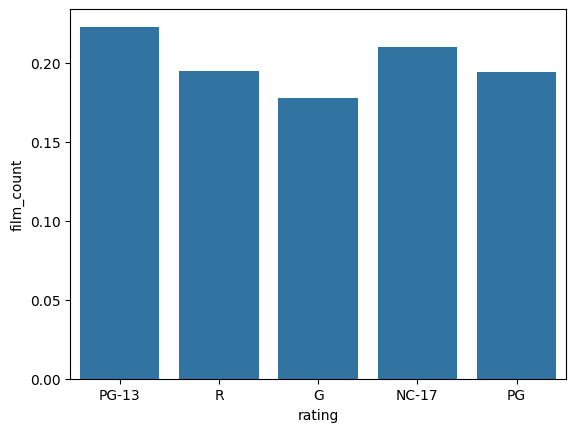

In [10]:
df = pd.DataFrame(result, columns=columns)

total_films = df['film_count'].sum()

df['film_count'] /= total_films
sns.barplot(data=df, x='rating', y='film_count')

In [11]:
#Какие категории фильмов чаще всего арендуются клиентами?
QUERY_2 = '''SELECT film.rating, COUNT(*) as count
             FROM film 
             GROUP BY film.rating
             ORDER BY count DESC
             '''

result = db_fetch(QUERY_2)
columns = ['rating', 'film_count']
save_to_csv(result, columns, 'query_2.csv')

df = pd.DataFrame(result, columns=columns)

<Axes: xlabel='rating', ylabel='film_count'>

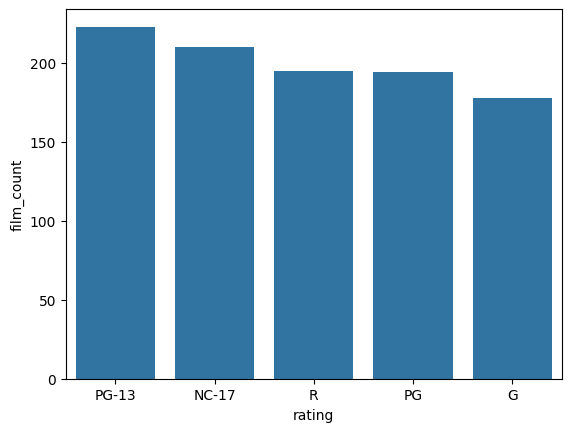

In [12]:
sns.barplot(data=df, x='rating', y='film_count')

Топ-3 фильмов которы берутся в аренду по убыванию: PG-13, NC-17, R

In [13]:
# Какова средняя продолжительность проката (rental duration) для каждой категории фильмов?
QUERY_3 = '''SELECT 
    film.rating, 
    AVG(EXTRACT(EPOCH FROM (rental.return_date - rental.rental_date))) / 3600 AS average_rental_duration_hours
    FROM rental
    JOIN inventory ON rental.inventory_id = inventory.inventory_id
    JOIN film ON inventory.film_id = film.film_id
    GROUP BY film.rating;
            '''

result = db_fetch(QUERY_3)
columns = ['rating', 'mean_duration']
save_to_csv(result, columns, 'query_3.csv')

df = pd.DataFrame(result, columns=columns)

<Axes: xlabel='rating', ylabel='mean_duration'>

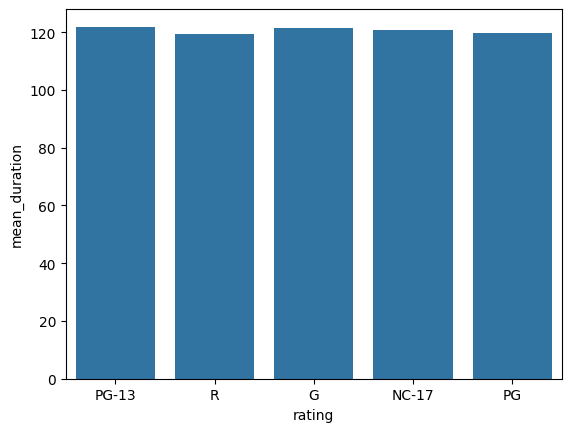

In [14]:
sns.barplot(data=df, x='rating', y='mean_duration')

In [15]:
# Каковы тенденции в ежемесячном доходе от проката(monthly rental revenue) и продажах (sales) за прошедший год?
QUERY_4 = '''
select 
	count(payment.amount) as sales,
	sum(payment.amount) as revenue,
	EXTRACT(MONTH FROM payment.payment_date) as m,
	EXTRACT(YEAR FROM payment.payment_date) as y
from payment 
group by 
    EXTRACT(MONTH FROM payment.payment_date),
    EXTRACT(YEAR FROM payment.payment_date)'''

result = db_fetch(QUERY_4)
columns = ['sales', 'revenue', 'month', 'year']
save_to_csv(result, columns, 'query_4.csv')

df = pd.DataFrame(result, columns=columns)

In [16]:
# Оставляем только 2005 год 
df = df[df['year'] == 2005]
df['m'] = df['month'].astype(str)




<Axes: xlabel='m', ylabel='sales'>

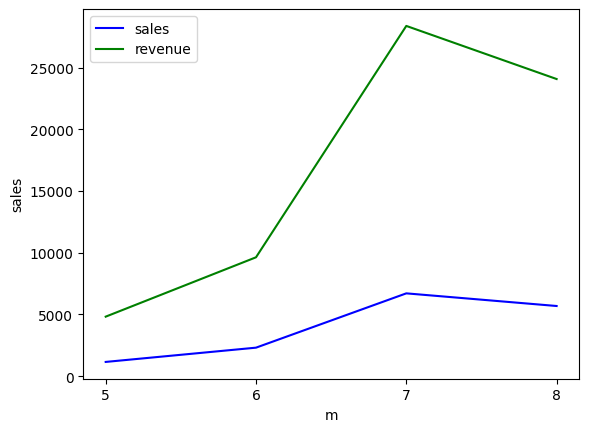

In [17]:
df_ = df.sort_values('m', ascending=True)

sns.lineplot(df_, x='m', y='sales', color="blue", label = 'sales')
sns.lineplot(df_, x='m', y='revenue', color="green", label = 'revenue')


In [18]:
# Как соотносятся показатели продаж в разных магазинах?
QUERY_5 = '''
SELECT count(amount) as sales, sum(amount) as revenue, store_id
from payment  
join customer ON payment.customer_id = customer.customer_id
group by store_id'''

result = db_fetch(QUERY_5)
columns = ['sales', 'revenue', 'store_id']
save_to_csv(result, columns, 'query_5.csv')


df = pd.DataFrame(result, columns=columns)


<Axes: xlabel='store_id', ylabel='revenue'>

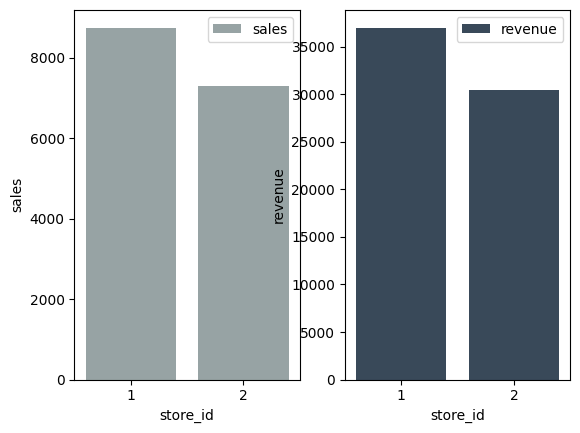

In [19]:
fig, axes = plt.subplots(1, 2)
sns.barplot(data=df, x='store_id', y='sales', label='sales', color = "#95a5a6", ax = axes[0]) 
sns.barplot(data=df, x='store_id', y='revenue', label='revenue', color = "#34495e", ax = axes[1])


In [20]:
# Каковы средние затраты на замену(replacement_cost) фильмов в разных жанрах?
QUERY_6 = '''
select 
	category.name as category, avg(film.replacement_cost) as avg_cost
from film
join film_category on film.film_id = film_category.film_id
join category on film_category.category_id = category.category_id 
group by category.name
'''
result = db_fetch(QUERY_6)
columns = ['category', 'avg_cost']
save_to_csv(result, columns, 'query_6.csv')

df = pd.DataFrame(result, columns=columns)
    

<Axes: xlabel='category', ylabel='avg_cost'>

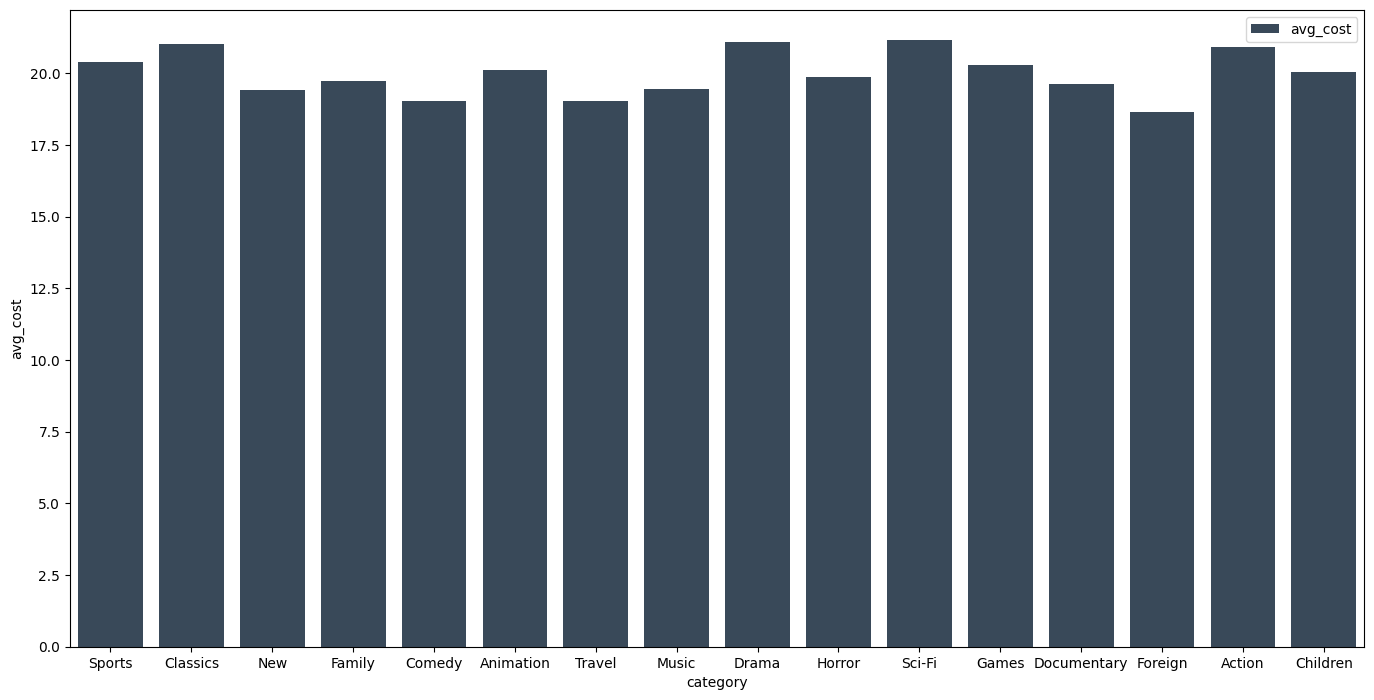

In [21]:
from matplotlib import pyplot
a4_dims = (16.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)


sns.barplot(data=df, x='category', y='avg_cost', label='avg_cost', color = "#34495e")

In [22]:
# Какие актеры снимаются в самых разных жанрах фильмов?
QUERY_7 = '''
select 
	actor.actor_id as actor_id, actor.first_name, actor.last_name, count(film_category.category_id) as counter
from actor
join film_actor on film_actor.actor_id = actor.actor_id
join film on film.film_id = film_actor.film_id
join film_category on film_category.film_id = film.film_id
group by actor.actor_id
order by counter desc '''

result = db_fetch(QUERY_7)
columns = ['actor_id', 'first_name', 'last_name', 'genres']
save_to_csv(result, columns, 'query_7.csv')

df = pd.DataFrame(result, columns=columns)

<Axes: xlabel='actor_id', ylabel='genres'>

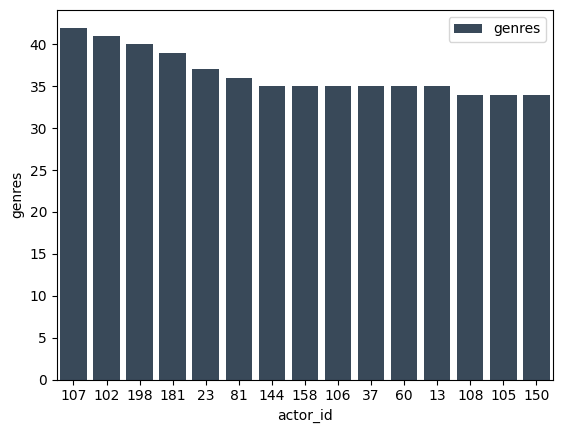

In [23]:
df_ = df.sort_values('genres', ascending=False)[:15]

sns.barplot(data=df_, x='actor_id', y='genres', label='genres', color = "#34495e", order=df_.sort_values('genres', ascending=False).actor_id)
